In [440]:
import pandas as pd
import numpy as np
import datetime

# plot imports
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


# moddeling and forecasting
from xgboost import XGBRegressor


In [441]:
df = pd.read_csv("../measurements")

df.head()

,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea,ID,Week,Date
229,Satine,RGB_1.png,Depth_1.png,2.6,0.14,8.2,12.0,80.6,1,2021-W1,2021-01-04
362,Satine,RGB_2.png,Depth_2.png,2.1,0.10,8.5,8.2,67.4,2,2021-W1,2021-01-04
258,Satine,RGB_3.png,Depth_3.png,2.0,0.09,7.5,9.5,65.0,3,2021-W1,2021-01-04
263,Satine,RGB_4.png,Depth_4.png,2.7,0.13,6.0,10.6,78.7,4,2021-W1,2021-01-04
224,Lugano,RGB_5.png,Depth_5.png,2.3,0.11,8.3,9.8,73.9,5,2021-W1,2021-01-04


In [442]:
df["Date"].unique()

array(['2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
       '2021-02-01', '2021-02-08', '2021-02-15'], dtype=object)

In [443]:
def prepare_dataframe(df, variety):
    #%Y-%m-%d
    df['date_time'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    # # changed in dex to date
    df.head()
    df = df.set_index('date_time')


    # splice of unecessary colums and rows
    df = df.loc(axis=1)["Variety", "FreshWeightShoot", "DryWeightShoot", "Height", "Diameter", "LeafArea","ID"]
    df = df.loc[df["Variety"] == variety]


    df = df.sort_index()
    return df

In [444]:
df = prepare_dataframe(df, "Satine")

In [445]:
def split_data(train_weeks, validation_weeks):
    # Raises exception when te requested amount of weeks is to big
    if train_weeks + validation_weeks > 6:
        raise Exception("To many weeks!")

    # Calculate datetime from weeks
    start_date = datetime.datetime(2021,1,4)
    end_train_date = start_date + datetime.timedelta(weeks=train_weeks -1 )
    end_validation_date = end_train_date + datetime.timedelta(weeks=validation_weeks)

    #format datetime to %Y-%m-%d
    end_train_date = end_train_date.strftime(format='%Y-%m-%d')
    end_validation_date = end_validation_date.strftime(format='%Y-%m-%d')


    data_train = df.loc[: end_train_date, :]
    data_val   = df.loc[end_train_date:end_validation_date, :]
    data_test  = df.loc[end_validation_date:, :]

    return data_train, data_val, data_test



In [446]:
data_train, data_val, data_test = split_data(4,2)

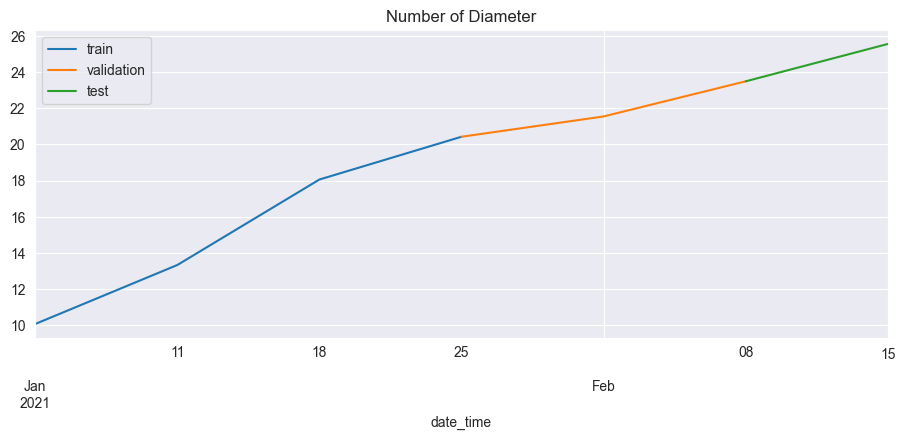

In [447]:
data_val_mean = data_val.groupby('date_time').mean()
data_test_mean = data_test.groupby('date_time').mean()
data_train_mean = data_train.groupby('date_time').mean()

fig, ax = plt.subplots(figsize=(11, 4))
data_train_mean['Diameter'].plot(ax=ax, label='train')
data_val_mean['Diameter'].plot(ax=ax, label='validation')
data_test_mean['Diameter'].plot(ax=ax, label='test')
ax.set_title(' Diameter')
ax.legend();

XGBoost

In [ ]:
def create_forecaster(lags):
    forecaster = ForecasterAutoreg(
        regressor = XGBRegressor(random_state=123),
        lags = lags
    )
    return forecaster

forecaster = create_forecaster(24)

forecaster